# kNN in Python
## Vorbereitung
### Module laden

In [1]:
# Import dstools (absolute path required, please change to your systems settings)
import importlib
import sys

path = '/dstools-master/dstools/__init__.py'
name = 'dstools'

spec = importlib.util.spec_from_file_location(name, path)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 

from dstools import quality
from dstools.metrics import classificationreport, confusion_matrix
from dstools.datasets import iris
from dstools.datasets import abalones

### Daten laden

In [3]:
dfa = iris()
dfa.head()

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
dfa = abalones()
dfa.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [10]:
dfa = dfa.to_numeric()
dfa.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_cat
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1


In [6]:
quality(dfa)

Dataframe has 4,177 rows and 9 columns.

0 column(s) with missing values.

8 column(s) with outliers.



,type,unique,missing_abs,missing_rel,outliers_abs,outliers_rel
Length,float64,134,0,0.0,49,1.17
Diameter,float64,111,0,0.0,59,1.41
Height,float64,51,0,0.0,29,0.69
Whole weight,float64,2429,0,0.0,30,0.72
Shucked weight,float64,1515,0,0.0,48,1.15
Viscera weight,float64,880,0,0.0,26,0.62
Shell weight,float64,926,0,0.0,35,0.84
Rings,int64,28,0,0.0,278,6.66
Sex_cat,int8,3,0,0.0,0,0.00


### Prädiktormatrix und Responsevariable definieren

In Python ist es notwendig, die Prädiktormatrix $X$ und die Responsevariable $y$ in **zwei getrennten** Objekten zu speichern. Obwohl kNN eigentlich kein Training durchführt, ist es üblich, auch hier ein Test- und Trainingsset zu definieren. 

Es gibt in `sklearn` die Funktion `train_test_split`, die einen gegebenen Datensatz nach bestimmten Parametern in Trainings- und Testdaten teilt.

In [5]:
dfa['Whole weight'] = pd.cut(dfa['Whole weight'], bins=3, labels=[0, 1, 2])

X = dfa.drop(["Whole weight", "Sex"], axis=1)
y = dfa['Whole weight']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=147)

### Daten visualisieren

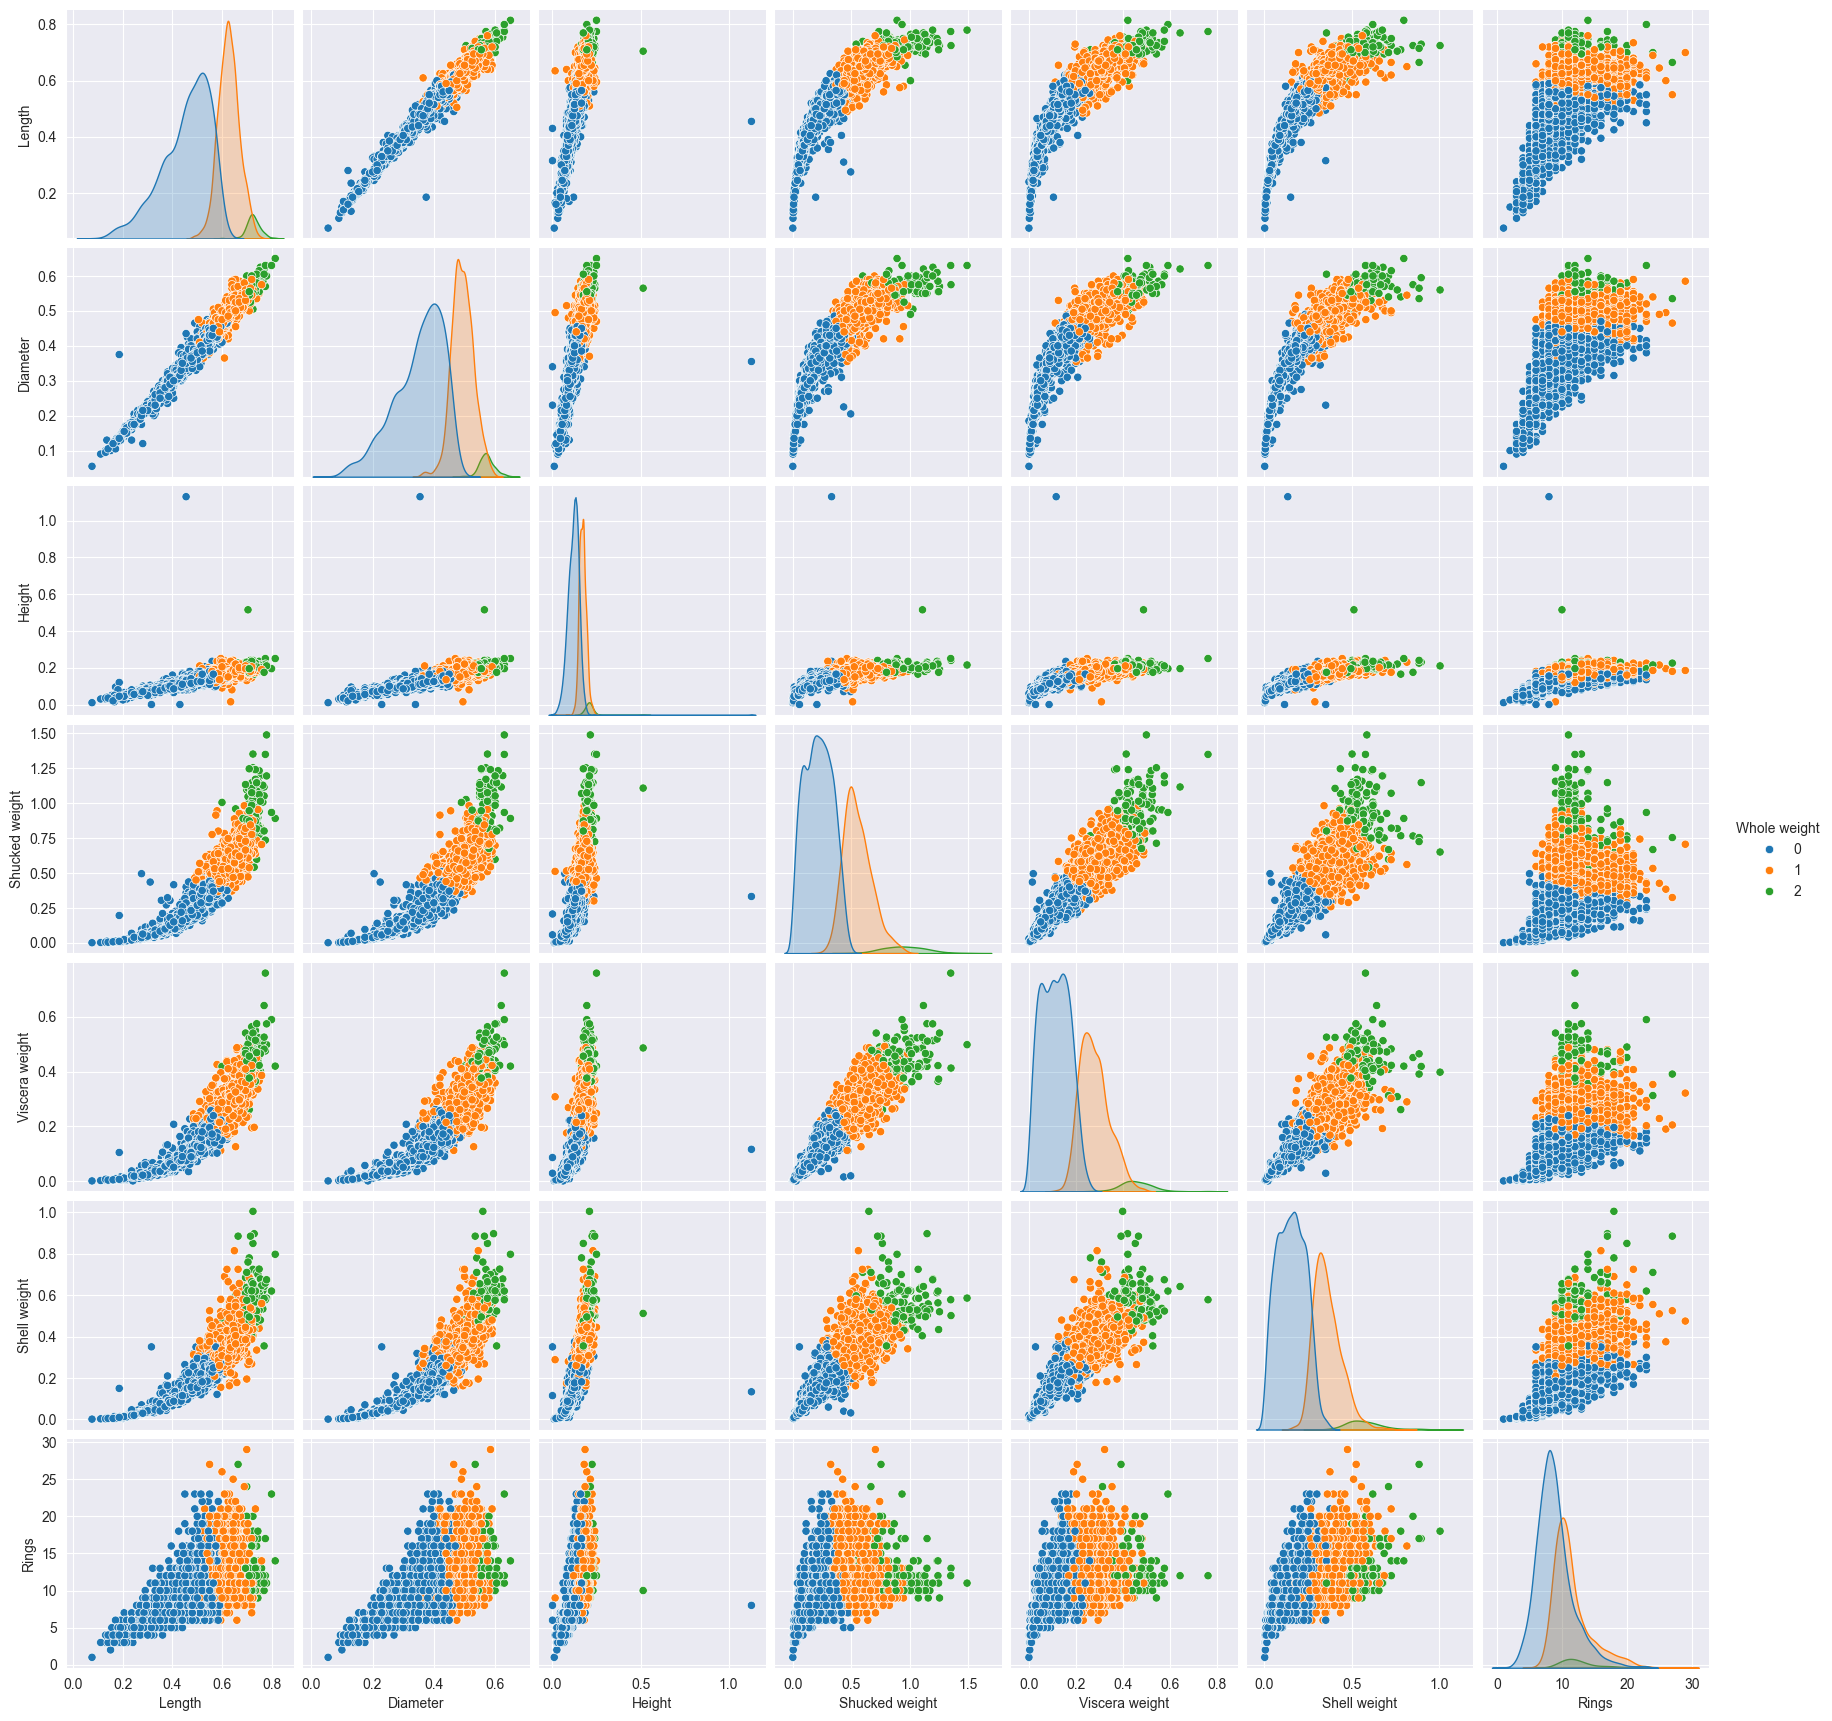

In [7]:
sns.pairplot(dfa, hue='Whole weight');

## kNN durchführen

kNN wird in 3 Schritten durchgeführt:

1. die Parameter der kNN festlegen (Wert für $k$, Distanzfunktion)
1. das Modell mit den Trainingsdaten anpassen
1. die Distanzen zu den $k$ nächsten Nachbarn für jeden Datenpunkt der Testdaten berechnen und die Zugehörigkeit bestimmen

Sind zwei Punkte gleich weit entfernt, bestimmt die Sortierung der Trainingsdaten welcher genommen wird.

### Ohne Standardisierung

Zunächst betrachten wir ein Modell mit 5 Nachbarn und der euklidischen Distanz. Die Datenpunkte werden nicht standardisiert. Die euklidische Distanz ist eine Minkowski-Metrik mit $p=2$. Daher benötigt unser Klassifikator folgende Parameter: 

- `n_neighbors=5`
- `p=2`
- `metric='minkowski'`

In [8]:
knn = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')

In [9]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

Ein weiterer wichtiger Parameter, den man variieren kann, ist `weights`. Er akzeptiert folgende Werte:

- `uniform`: Alle Punkte in der Umgebung haben das gleiche Gewicht
- `distance`: Die Punkte werden invers zu ihrem Abstand (1/Abstand) gewichtet. Je näher sich ein Punkt befindet, desto wichtiger ist er für die Klassenzugehörigkeit

Weitere Informationen: 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [10]:
pred = knn.predict(X_test)

Wir wollen nun wissen, wie gut unser Modell klassifiziert hat.

In [11]:
from dstools.metrics import confusion_matrix

In [12]:
conf_matrix = confusion_matrix(pred, y_test)
conf_matrix

Actual,0,1,2
Predicted,,,
0,809,23,0
1,15,489,17
2,0,3,23


Grafikfreunde können sich die Confusion_matrix auch als Heatmap anzeigen lassen:

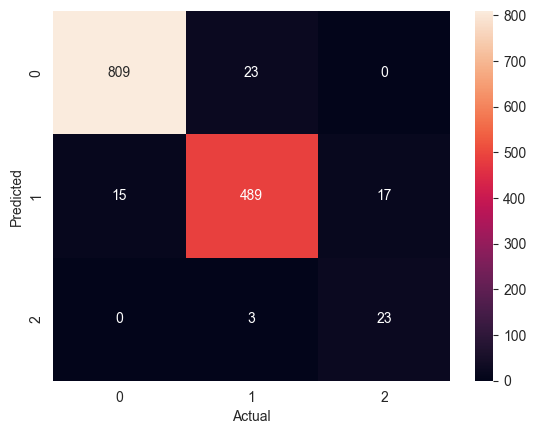

In [13]:
sns.heatmap(conf_matrix, annot=True, fmt="0");

Die Accuracy kann man sich einfach über `accuracy_score` ausgeben lassen:

In [14]:
accuracy_score(y_test, pred)

0.9579405366207396

Eine detailliertere Auswertung bekommt man mit `classification_report`:

In [15]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       824
           1       0.94      0.95      0.94       515
           2       0.88      0.57      0.70        40

    accuracy                           0.96      1379
   macro avg       0.93      0.84      0.87      1379
weighted avg       0.96      0.96      0.96      1379



`support` gibt an, wie oft das Merkmal in den Testdaten vorhanden war. Eine ausführlichere Beschreibung liefert `classificationreport` aus den `dstools`:

In [16]:
print(classificationreport(conf_matrix))

              Precision    Recall        F1   Support

     Class 1      0.982     0.972     0.977       832
     Class 2      0.950     0.939     0.944       521
     Class 3      0.575     0.885     0.697        26

   macro avg      0.835     0.932     0.873      1379
weighted avg      0.962     0.958     0.959      1379

    Accuracy                          0.958      1379
 Cohen Kappa                          0.916      1379



D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return 

### Mit Standardisierung

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

In [19]:

knn_z = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
knn_z.fit(X_train_z, y_train)

pred_z = knn_z.predict(X_test_z)


In [20]:
conf_matrix_z =  confusion_matrix(pred_z, y_test)
conf_matrix_z

Actual,0,1,2
Predicted,,,
0,812,29,0
1,12,483,8
2,0,3,32


In [66]:
print(classificationreport(conf_matrix_z))

              Precision    Recall        F1   Support

     Class 1      0.985     0.966     0.975       841
     Class 2      0.938     0.960     0.949       503
     Class 3      0.800     0.914     0.853        35

   macro avg      0.908     0.947     0.926      1379
weighted avg      0.963     0.962     0.963      1379

    Accuracy                          0.962      1379
 Cohen Kappa                          0.924      1379



D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Uni\5. Semester\Data Mining\venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return 

### Mit Cross-Validation

Da uns in diesem einfachen Beispiel die nicht-standardisierten Werte bessere Ergebnisse liefern, machen wir mit diesen weiter. 

Die Ergebnisse der CV speichern wir in einem Array, das wir zunächst erzeugen:

In [67]:
cv_scores = []

Nun führen wir eine 10-fold CV durch und speichern die mittlere Accuracy in unserem `cv_scores`-Array:

In [68]:
k_values = range(2,50)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

Suchen wir das optimale $k$:

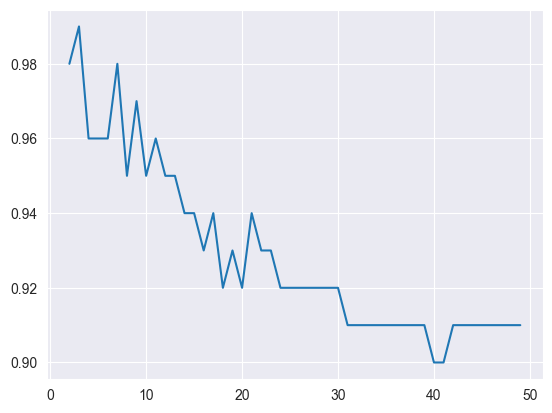

In [34]:
plt.plot(k_values, cv_scores);

Was ist nun das beste $k$? Erzeugen wir uns einen Pandas-Dataframe und suchen uns die Einträge mit der höchsten Accuracy:

In [ ]:
k_acc = pd.DataFrame({'k': k_values, 'Acc': cv_scores})
k_acc[k_acc['Acc'] == max(k_acc['Acc'])]

Nun könnten wir noch weiter Parameter variieren, um zwischen den beiden resultierenden $k$s zu unterscheiden.

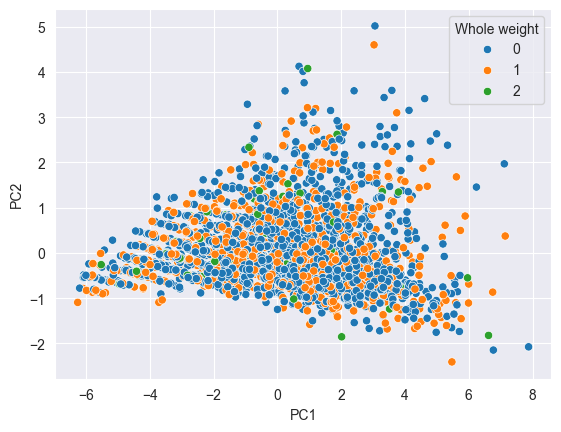

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
ssc.fit(X_train)
X_train_z = ssc.transform(X_train)

pca = PCA()
princComp = pca.fit_transform(X_train_z)
df_raw = pd.DataFrame(data=princComp, columns=['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
df = pd.concat([df_raw, pd.Series(y, name='Whole weight')], axis=1)
df.head()
sns.scatterplot(x="PC1", y="PC2", hue="Whole weight", data=df);

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA()
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

label_dict = {1: 'I', 2: 'F', 3:'M'}

In [39]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

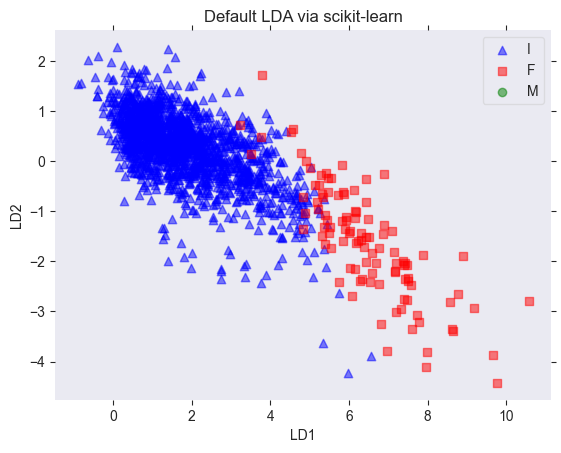

In [40]:
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')